# The effect of COVID-19 on deliveredKwh
We designed two machine learning-based model (SVM-based) that to predict the value of "dailyDeleivered". 

We monitored the prediction error of the pre and post COVID data to observe the effect of COVID-19 on the prediction error. 
We also observed the sign of the prediction error to see whether the predicted dailyDelivered values are greater or less than the actula values.
The following code and results are for a dataset that contains data of residential premises.

The prediction error for post-covid data is greater than the one for pre-covid data.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as ds
import sklearn.model_selection as ms
import sklearn.svm as svm
from numpy import genfromtxt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from operator import add
#rom keras.backend import tensorflow_backend as K

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
def temporalize(arr,win_size,step_size,features,add_index=0):
  """
  arr: any 2D array whose columns are distinct variables and 
    rows are data records at some timestamp t
  win_size: size of data window (given in data points)
  step_size: size of window step (given in data point)
  
  Note that step_size is related to window overlap (overlap = win_size - step_size), in 
  case you think in overlaps."""
  #
  dataFrameTimeseries=pd.DataFrame()
  #
  w_list = list()
  n_records = arr.shape[0]
  remainder = (n_records - win_size) % step_size 
  num_windows = 1 + int((n_records - win_size - remainder) / step_size)
  for k in range(num_windows):
    w_list.append(arr[k*step_size:win_size-1+k*step_size+1])
    #
    #convert the matrix to data frame
    dataFrameTemp=pd.DataFrame(data=arr[k*step_size:win_size-1+k*step_size+1], columns=features)
    dataFrameTemp["timeseriesId"]=k+add_index
    dataFrameTimeseries=pd.concat([dataFrameTimeseries,dataFrameTemp])
    #
  return np.array(w_list),dataFrameTimeseries


In [3]:
def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            pass
        
        try:
            import unicodedata
            unicodedata.numeric(s)
            return True
        except (TypeError, ValueError):
            pass
        return False 

In [4]:
def plot_(h_axis,v1_axis,v2_axis, title="Daily Delivered (kWh)"):
    plt.rcParams.update({'font.size': 15})
    plt.tight_layout()
    plt.figure(figsize=(30,3))
    plt.plot(h_axis, v1_axis, color="blue",marker="o", label="actual")
    plt.plot(h_axis,v2_axis, color="red",marker="o",label="predicted")
    plt.xticks(h_axis[0::31],rotation=90)
    plt.title(title)
    plt.show()

In [5]:
# split into train and test sets
def split_(dataset, train_size=0.67, dimension=2):
    train_size = int(len(dataset) * train_size)
    test_size = len(dataset) - train_size
    train=[]
    test=[]
    if dimension==1:
        train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    else:
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train,test

In [6]:
def svm_poly(X,Y,trainig_percentage=0.76):
    
    model = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
    
    #train on precovid data and test on all dataset
    Xtrain,Xtest=split_(X,trainig_percentage)
    Ytrain,Ytest=split_(Y,trainig_percentage,1)
    
    model.fit(Xtrain, Ytrain)
    
    #prediction error on pre-covid data (training data)
    yhat1=model.predict(Xtrain)
    prediction_error1=np.square(Ytrain-yhat1).mean(axis=None).ravel()
    print("prediction error on pre-covid data")
    print("**********************************")
    print(prediction_error1)
    
    #prediction error on post-covid data (testing data)
    yhat2 = model.predict(Xtest)
    prediction_error2=np.square(Ytest-yhat2).mean(axis=None).ravel()
    print("prediction error on post-covid data")
    print("**********************************")
    print(prediction_error2)
    
    print("Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted")
    print("**********************************")
    print((Ytest-yhat2).mean(axis=None))
    
    #predict the entire data
    yhat=model.predict(X)

    h_axis=dataset["time"]
    v1_axis=dataset["dailyDelivered"]
    v2_axis=yhat.flatten()
    #temp=np.zeros(win_size)
    #v2_axis=np.concatenate([temp,v2_axis])
    plot_(h_axis,v1_axis,v2_axis)

In [7]:
def svm_rbf(X,Y,trainig_percentage=0.76):
    
    model = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    
    #train on precovid data and test on all dataset
    Xtrain,Xtest=split_(X,trainig_percentage)
    Ytrain,Ytest=split_(Y,trainig_percentage,1)
    
    model.fit(Xtrain, Ytrain)
    
    #prediction error on pre-covid data (training data)
    yhat1=model.predict(Xtrain)
    prediction_error1=np.square(Ytrain-yhat1).mean(axis=None).ravel()
    print("prediction error on pre-covid data")
    print("**********************************")
    print(prediction_error1)
    
    #prediction error on post-covid data (testing data)
    yhat2 = model.predict(Xtest)
    prediction_error2=np.square(Ytest-yhat2).mean(axis=None).ravel()
    print("prediction error on post-covid data")
    print("**********************************")
    print(prediction_error2)
    
    print("Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted")
    print("**********************************")
    print((Ytest-yhat2).mean(axis=None))
    
    #predict the entire data
    yhat=model.predict(X)

    h_axis=dataset["time"]
    v1_axis=dataset["dailyDelivered"]
    v2_axis=yhat.flatten()
    #temp=np.zeros(win_size)
    #v2_axis=np.concatenate([temp,v2_axis])
    plot_(h_axis,v1_axis,v2_axis)

In [8]:
def svm_sig(X,Y,trainig_percentage=0.76):
    
    model = svm.SVR(kernel='sigmoid', C=100, gamma=0.1, epsilon=.1)
    
    #train on precovid data and test on all dataset
    Xtrain,Xtest=split_(X,trainig_percentage)
    Ytrain,Ytest=split_(Y,trainig_percentage,1)
    
    model.fit(Xtrain, Ytrain)
    
    #prediction error on pre-covid data (training data)
    yhat1=model.predict(Xtrain)
    prediction_error1=np.square(Ytrain-yhat1).mean(axis=None).ravel()
    print("prediction error on pre-covid data")
    print("**********************************")
    print(prediction_error1)
    
    #prediction error on post-covid data (testing data)
    yhat2 = model.predict(Xtest)
    prediction_error2=np.square(Ytest-yhat2).mean(axis=None).ravel()
    print("prediction error on post-covid data")
    print("**********************************")
    print(prediction_error2)
    
    print("Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted")
    print("**********************************")
    print((Ytest-yhat2).mean(axis=None))
    
    #predict the entire data
    yhat=model.predict(X)

    h_axis=dataset["time"]
    v1_axis=dataset["dailyDelivered"]
    v2_axis=yhat.flatten()
    #temp=np.zeros(win_size)
    #v2_axis=np.concatenate([temp,v2_axis])
    plot_(h_axis,v1_axis,v2_axis)

In [9]:
#set window sizes and their overlap
win_size=10
overlap=win_size-1

#read data
dataset = pd.read_csv('datasets/pow_temp_isweekday.csv', engine='python')

#preprocess data
dataset=dataset.fillna(-1)


for column in dataset.columns:
    if is_number(dataset.iloc[1][column]) and column!="id":
        min_max=MinMaxScaler(feature_range=(0, 1))
        dataset[[column]]=min_max.fit_transform(dataset[[column]])
       
#set variables based on the data attributes    
n_features=len(dataset.columns.values)
dailyDeliveredIndex=np.where(dataset.columns.values=="dailyDelivered")
dailyDeliveredIndex=dailyDeliveredIndex[0][0]

X_ = dataset[["id", "Temp", "isWeekend"]].values
y_ = dataset[["id", "dailyDelivered"]].values


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


prediction error on pre-covid data
**********************************
[0.02205065]
prediction error on post-covid data
**********************************
[0.03783542]
Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted
**********************************
-0.04272499101230079


<Figure size 432x288 with 0 Axes>

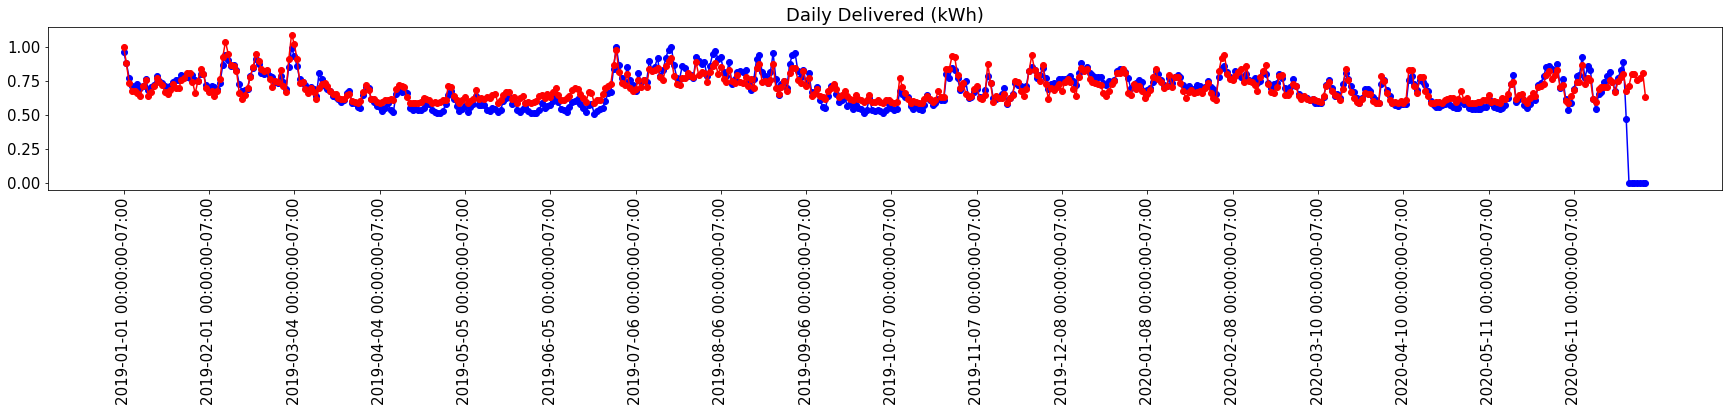

In [10]:
svm_poly(X_[:,1:], y_[:,1:])

prediction error on pre-covid data
**********************************
[0.02035495]
prediction error on post-covid data
**********************************
[0.03609991]
Error sign (actual-prediction) for post covid data: If Positive--> actual is greater than predicted
**********************************
-0.04084605080057632


C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

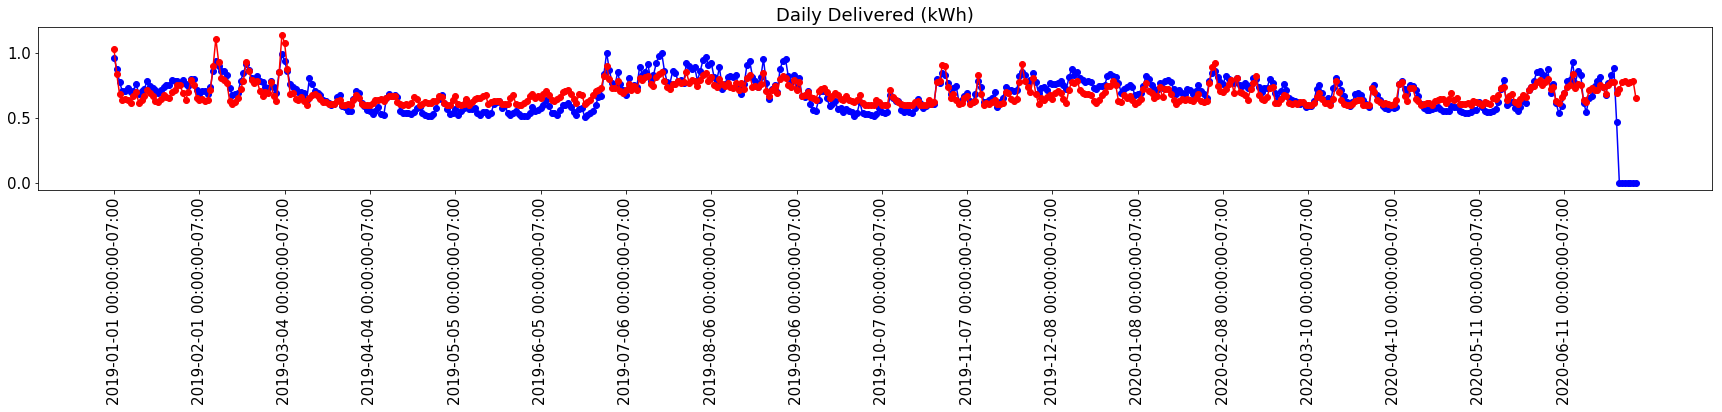

In [11]:
svm_rbf(X_[:,1:], y_[:,1:])